In [1]:
import os

# DWD proxy
os.environ["HTTP_PROXY"]  = "http://ofsquid.dwd.de:8080"
os.environ["HTTPS_PROXY"] = "http://ofsquid.dwd.de:8080"

# Optional but recommended
os.environ["http_proxy"]  = os.environ["HTTP_PROXY"]
os.environ["https_proxy"] = os.environ["HTTPS_PROXY"]

In [3]:
import os
import httpx

# --- force bypass proxy for localhost ---
os.environ["NO_PROXY"] = "localhost,127.0.0.1"
os.environ["no_proxy"] = "localhost,127.0.0.1"

BASE = "http://localhost:11434"

def get(path):
    url = BASE + path
    with httpx.Client(timeout=10, trust_env=False) as client:  # <--- key
        r = client.get(url)
        print("GET", path, "->", r.status_code)
        print(r.text[:500])
        return r

# These are standard Ollama endpoints
get("/api/tags")        # list models
get("/api/version")     # version info


GET /api/tags -> 200
{"models":[{"name":"qwen3-vl:30b","model":"qwen3-vl:30b","modified_at":"2026-01-17T11:14:52.233742099+01:00","size":19595410062,"digest":"eda0be1008774ea4e575187712b9a3b1201f3e66e7ecff899cc295db1cf00248","details":{"parent_model":"","format":"gguf","family":"qwen3vlmoe","families":["qwen3vlmoe"],"parameter_size":"31.1B","quantization_level":"Q4_K_M"}},{"name":"deepseek-r1:latest","model":"deepseek-r1:latest","modified_at":"2025-12-29T13:28:01.128466397+01:00","size":5225376047,"digest":"6995872b
GET /api/version -> 200
{"version":"0.13.5"}


<Response [200 OK]>

In [13]:
# ============================================================
# Local Ollama test in Jupyter: qwen3-vl:30b (Vision-Language)
# Streams into a live Markdown cell output (nice in Jupyter)
# Works with DWD proxy env vars because trust_env=False.
# Endpoint: http://localhost:11434/api/generate
# ============================================================

import os, json, base64
import httpx
from pathlib import Path

from IPython.display import display, Markdown, clear_output

BASE = "http://localhost:11434"
OLLAMA_URL = f"{BASE}/api/generate"
MODEL = "qwen3-vl:30b"   # <-- confirmed from /api/tags

def b64_image(path: str) -> str:
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"Image not found: {path}")
    return base64.b64encode(p.read_bytes()).decode("utf-8")

def ollama_generate(prompt: str, image_paths=None, stream=True, timeout=300, markdown=True) -> str:
    payload = {
        "model": MODEL,
        "prompt": prompt,
        "stream": stream
    }
    if image_paths:
        payload["images"] = [b64_image(p) for p in image_paths]

    headers = {"Content-Type": "application/json"}

    # trust_env=False = ignore HTTP_PROXY/HTTPS_PROXY in environment
    with httpx.Client(timeout=timeout, trust_env=False) as client:

        if not stream:
            r = client.post(OLLAMA_URL, json=payload, headers=headers)
            if r.status_code != 200:
                raise RuntimeError(f"HTTP {r.status_code}\n{r.text}")
            return r.json().get("response", "")

        full = []
        rendered = ""

        # initial placeholder so the cell shows output immediately
        if markdown:
            display(Markdown("*(waiting for first token...)*"))

        with client.stream("POST", OLLAMA_URL, json=payload, headers=headers) as r:
            if r.status_code != 200:
                body = r.read().decode("utf-8", errors="replace")
                raise RuntimeError(f"HTTP {r.status_code}\n{body}")

            for line in r.iter_lines():
                if not line:
                    continue
                try:
                    data = json.loads(line)
                except Exception:
                    continue

                chunk = data.get("response", "")
                if chunk:
                    full.append(chunk)

                    if markdown:
                        rendered += chunk
                        clear_output(wait=True)
                        display(Markdown(rendered))
                    else:
                        print(chunk, end="", flush=True)

                if data.get("done", False):
                    break

        if not markdown:
            print()

        return "".join(full)

# ------------------------------------------------------------
# Test 1: text only
# ------------------------------------------------------------
resp = ollama_generate("Explain in 3 bullets what a vision-language model does.", stream=True, markdown=True)


Here's what a vision-language model does in 3 concise bullets:

*   **Fuses visual and textual understanding:** It processes both images/videos and text simultaneously to grasp the *relationships* between them (e.g., identifying objects in a picture and linking them to their names).
*   **Enables cross-modal generation:** It can generate new content based on the other modality, such as creating images from text descriptions or writing descriptive captions for images.
*   **Performs complex reasoning across modalities:** It understands context, intent, and inconsistency between vision and language (e.g., answering "Why is this object wrong in the image?" or reasoning about actions depicted in a video).

In [14]:
Markdown(resp)

Here's what a vision-language model does in 3 concise bullets:

*   **Fuses visual and textual understanding:** It processes both images/videos and text simultaneously to grasp the *relationships* between them (e.g., identifying objects in a picture and linking them to their names).
*   **Enables cross-modal generation:** It can generate new content based on the other modality, such as creating images from text descriptions or writing descriptive captions for images.
*   **Performs complex reasoning across modalities:** It understands context, intent, and inconsistency between vision and language (e.g., answering "Why is this object wrong in the image?" or reasoning about actions depicted in a video).

In [11]:
# ------------------------------------------------------------
# Test 2: image + text 
# ------------------------------------------------------------
img = "cth_map.png"   # <-- adjust path
resp2 = ollama_generate("Describe the image precisely; mention any text you see. What interpretation can you offer?", image_paths=[img], stream=True)

### Precise Description of the Image  

- **Title**: At the top center, the text reads *“Cloud Top Height (CTH) over Central Europe”*.  
- **Color Bar**: On the right side of the image, a vertical color bar is labeled *“Cloud Top Height (m)”* (unit: meters). It uses a gradient scale:  
  - Dark purple (at the bottom) corresponds to **2500 m** (lowest cloud top height).  
  - Transitioning through blue, teal, green, and yellow, the scale ends with **22500 m** (highest cloud top height, at the top of the bar).  
- **Geographic Map**: The map displays the landmasses of Central Europe, with visible country borders (e.g., UK, France, Germany, Italy, Spain, Poland, and surrounding regions). The colored regions overlay the landmasses to represent cloud top height.  
  - *Dark purple/blue areas*: Indicate **lower cloud top heights** (2500–10000 m).  
  - *Green/yellow areas*: Indicate **higher cloud top heights** (15000–22500 m).  
  - *White patches*: Likely represent regions with no data, low-resolution cloud coverage, or specific cloud types not captured by the measurement (e.g., very thin clouds or areas with minimal cloud presence).  


### Interpretation  

1. **What “Cloud Top Height (CTH)” Means**:  
   CTH measures the altitude (in meters) of the top of a cloud layer. Higher CTH values correspond to *taller clouds* (e.g., cumulonimbus clouds, often associated with storms), while lower CTH values correspond to *lower clouds* (e.g., stratus clouds, typical of overcast or foggy conditions).  

2. **Weather and Meteorological Context**:  
   - The predominance of **dark purple/blue** across most of Central Europe suggests widespread *low-to-moderate height clouds* (e.g., stratus or stratocumulus), common in stable, calm weather or during mild precipitation events.  
   - Scattered **green/yellow** regions (e.g., in parts of the North Atlantic, eastern Europe, and the Balkans) indicate *high-altitude clouds*, likely linked to active weather systems (e.g., thunderstorms, cyclones, or frontal systems with deep convective activity).  
   - The **white patches** may reflect data gaps, regions with no clouds, or clouds too thin to register in the measurement system (common in satellite-based cloud height data).  

3. **Broader Significance**:  
   This map is likely derived from satellite observations or numerical weather prediction models. It helps meteorologists assess cloud structure, which is critical for forecasting precipitation, storm intensity, and atmospheric dynamics. For example, high CTH (yellow) areas might signal severe weather risk, while low CTH (purple) areas suggest calmer conditions.  


In summary, the image visually encodes vertical cloud structure over Central Europe, with color scale and geography enabling interpretation of atmospheric conditions—linking cloud height to weather systems and meteorological processes.

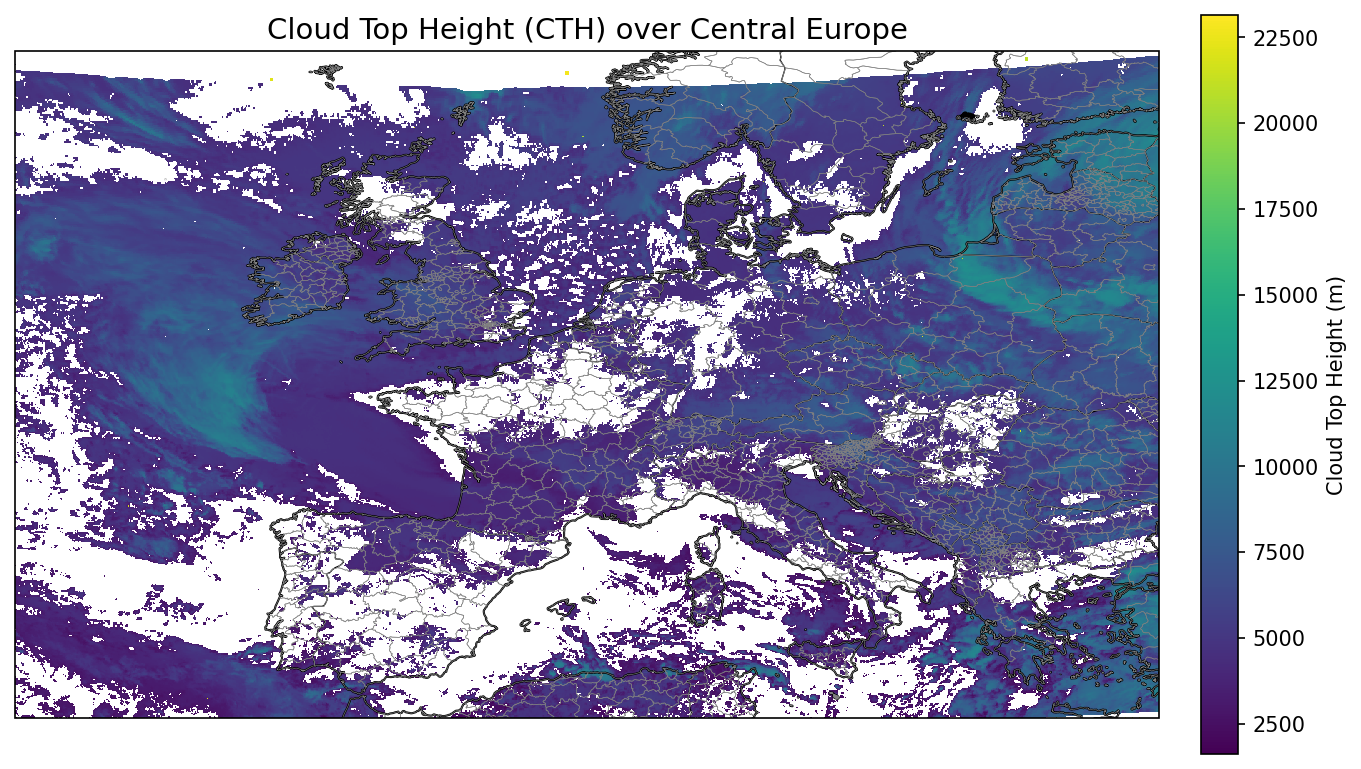

In [16]:
def show_image(path: str):
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"Image not found: {path}")
    display(Image.open(p))

show_image(img)